In [3]:
library(tidyverse)
library(glmnet)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loaded glmnet 2.0-13



In [12]:
load(file="data/GSE40279_r2.Rdata")
load(file="data/GSE41169_r2.Rdata")

In [52]:
# Age is stored in `characteristics_ch1` for training and `characteristics_ch1.6` for test in the metadata dataframes

# parse the strings and extract the age information
train.age  <- sapply(as.character(gse40279.meta$characteristics_ch1),
                     function(ch) as.numeric(unlist(strsplit(ch, ' '))[3]))
test.age  <- sapply(as.character(gse41169.meta$characteristics_ch1.6),
                     function(ch) as.numeric(unlist(strsplit(ch, ' '))[2]))

# remove names
names(train.age)  <- NULL
names(test.age)  <- NULL

In [54]:
# find common probes
train.probes  <- rownames(gse40279.data)
test.probes  <- rownames(gse41169.data)
common.probes  <- intersect(rownames(gse41169.data), rownames(gse40279.data))

# only select the common probes in training and test datasets
train.common  <- gse40279.data[common.probes,]
test.common  <- gse41169.data[common.probes,]

In [91]:
# number of common probes
length(common.probes)

[1] 118271

In [49]:
# summarize the ages in the training dataset
summary(train.age)
mean(train.age)
sd(train.age)
length(train.age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  19.00   54.00   65.00   64.04   75.00  101.00 

[1] 64.03506

[1] 14.73668

[1] 656

In [50]:
# summarize the ages in the test dataset
summary(test.age)
mean(test.age)
sd(test.age)
length(test.age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.00   24.50   29.00   31.57   36.00   65.00 

[1] 31.56842

[1] 10.28286

[1] 95

In [72]:
# inpute missing values based on means
imputeData  <- function(probeData) {
    probeData[is.na(probeData)]  <- mean(probeData, na.rm=T)
    return(probeData)
}

In [90]:
train.common.imputed  <- t(apply(train.common, 1, imputeData))
test.common.imputed  <- t(apply(test.common, 1, imputeData))

In [27]:
# Train glmnet for prediction
glmnet.Training.CV  <-  cv.glmnet(t(train.common.imputed), train.age, nfolds=10,alpha=0.5,family="gaussian")

# The definition of the lambda parameter:
lambda.glmnet.Training  <-  glmnet.Training.CV$lambda.min 
print(lambda.glmnet.Training)

[1] 0.6413943


In [28]:
# calculate the coefficients at the minimum lambda value
glmnet.coef  <- coef(glmnet.Training.CV, s=lambda.glmnet.Training)

In [29]:
# write out the coefficients
write.table(as.matrix(glmnet.coef), file='coefficients.csv', col.names = F, sep="\t")

In [33]:
# predict the age in the test set
pred.age.test <- predict(glmnet.Training.CV, newx = t(test.common.imputed), s = "lambda.min")
pred.age.train <- predict(glmnet.Training.CV, newx = t(train.common.imputed), s = "lambda.min")

In [37]:
# R^2 and correlation for training set
print(cor(pred.age.train, train.age)^2)
print(cor(pred.age.train, train.age))

# R^2 and correlation for training set
print(cor(pred.age.test, test.age)^2)
print(cor(pred.age.test, test.age))

       [,1]
1 0.9663555
       [,1]
1 0.9830338
       [,1]
1 0.9007898
       [,1]
1 0.9490995


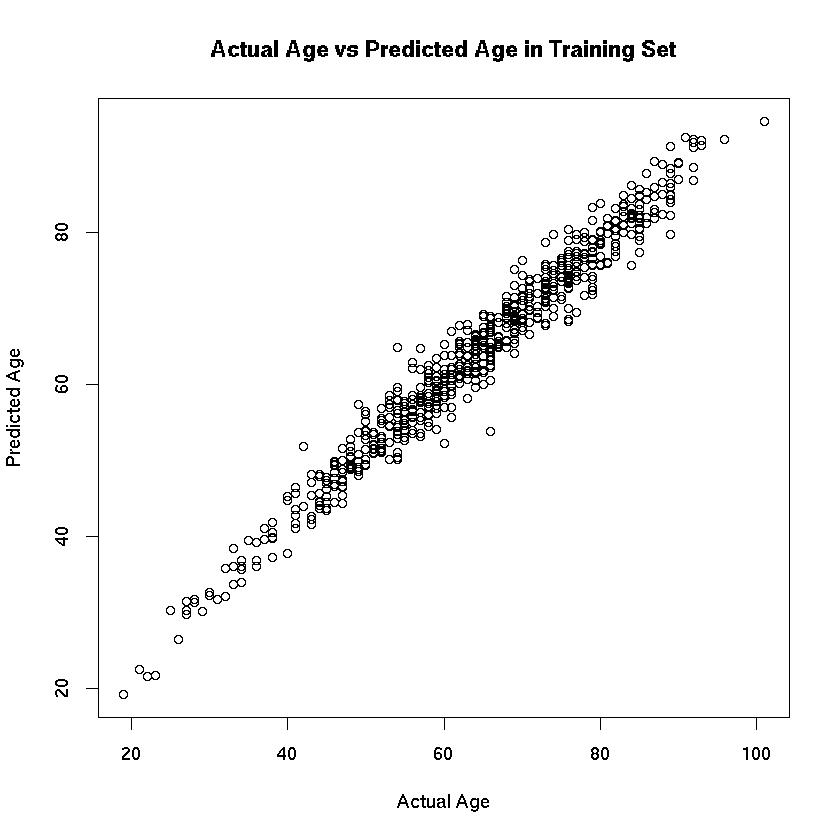

In [52]:
    # plotting predicted age vs actual age in training set
    plot(y=pred.age.train, x=train.age, ylab="Predicted Age", xlab="Actual Age", main="Actual Age vs Predicted Age in Training Set")

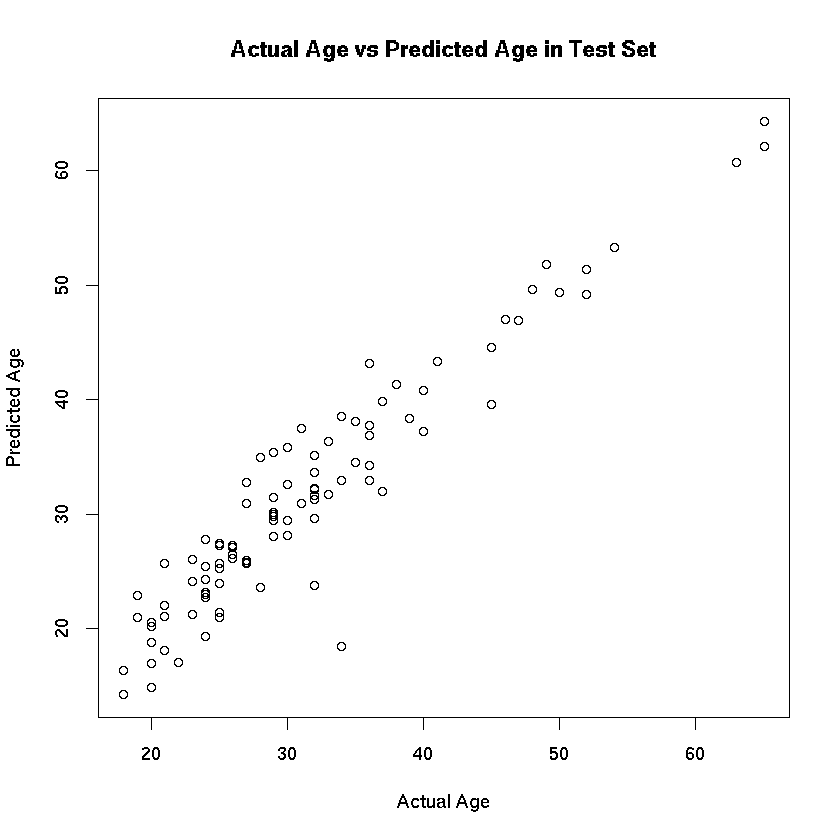

In [53]:
# plotting predicted age vs actual age in test set
plot(y=pred.age.test, x=test.age, ylab="Predicted Age", xlab="Actual Age", main="Actual Age vs Predicted Age in Test Set")

In [46]:
# Age accelerated
length(which(test.age > pred.age.test))

[1] 46

In [47]:
# Age decelerated
length(which(test.age < pred.age.test))

[1] 49

In [ ]:
# Test if age acceleration and deceleration is different between male and female
f.acc  <- length(which(test.age > pred.age.test))
f.dec  <- length(which(test.age < pred.age.test))

chisq.test()